In [22]:
!pip install nltk datasets peft loralib accelerate -U -q

In [23]:
import transformers
import datasets
import nltk, re, string
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [24]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

from datasets import load_dataset, Dataset, DatasetDict
import torch
import torch.nn.functional as F
from tqdm import tqdm
import xgboost as xgb


In [25]:
from transformers import AutoModelForSequenceClassification

In [26]:
data = datasets.load_dataset('ajaykarthick/imdb-movie-reviews')

#### EDA

In [27]:
df = pd.DataFrame(data['train'])
df.head()

,review,label
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0
1,"I have seen this film only once, on TV, and it...",0
2,I was only fourteen when I first saw the Alien...,1
3,This marvelous short will hit home with everyo...,0
4,If you are 10 years old and never seen a movie...,1


#### CLASS DISTRIBUTION

Both positive, and negative examples are balanced

<Axes: ylabel='Frequency'>

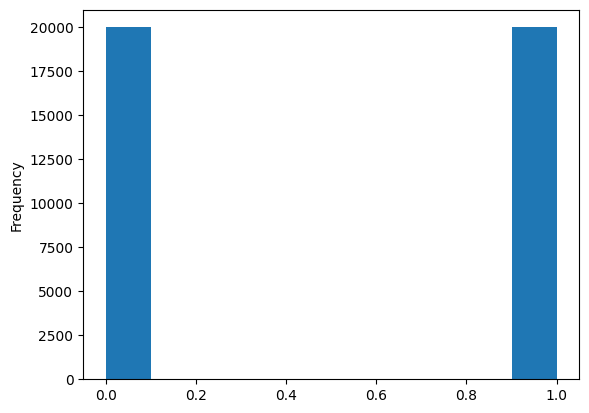

In [28]:
df['label'].plot(kind='hist')

distribution of the length of the reviews shows that most of the reviews have 4000 or less character

<Axes: ylabel='Frequency'>

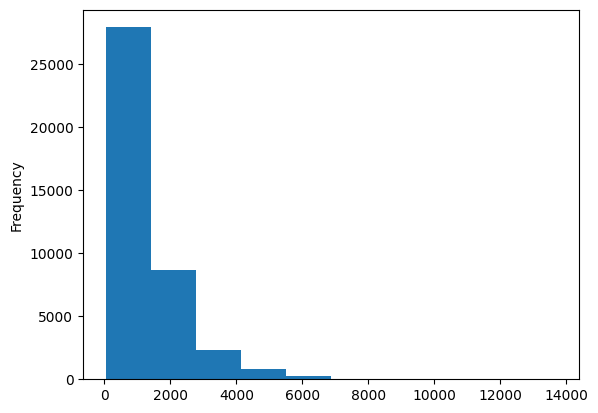

In [29]:
df['len'] = df['review'].apply(lambda x: len(x))
df['len'].plot(kind='hist')

#### APPROACH 1:
 TF-IDF Method is used to convert the documents into a vector
 different ML algorithms will be used to build models to make the classifications using these vectors

In [30]:
 nltk.download('stopwords')
 stopwords = nltk.corpus.stopwords
 stop_words = set(stopwords.words('english'))
 ps = nltk.PorterStemmer()


 def preprocess(tweet):
  tweet = tweet['review']
  tweet = tweet.lower()
  tweet = re.sub('<.*?>', '', tweet)
  tweet = ''.join([c for c in tweet if c not in string.punctuation])
  tweet = [word for word in tweet.split() if word not in stop_words]
  return {'cleaned' :' '.join(tweet)}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
data = data.map(preprocess)

In [32]:
pd.DataFrame(data['train'][0], index=[1])

,review,label,cleaned
1,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0,ms aparna sen maker mr mrs iyer directs movie ...


In [33]:
x_train, y_train = data['train']['cleaned'], data['train']['label']
x_test, y_test = data['test']['cleaned'], data['test']['label']

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x_train_v = tfidf.fit_transform(x_train)
x_test_v =  tfidf.transform(x_test)

In [35]:
import scipy.sparse as sp
x = sp.vstack([x_train_v, x_test_v])


In [36]:
y = y_train
y.extend(y_test)

In [37]:
tsvd = TruncatedSVD(n_components=70, random_state=37)
vec_matrix_tsvd = tsvd.fit_transform(x)
vec_matrix_tsvd

array([[ 0.11840415, -0.02229459,  0.01238321, ...,  0.00910866,
        -0.00865615, -0.01708514],
       [ 0.12185324, -0.04099973, -0.01853619, ..., -0.01885893,
         0.00184528, -0.00244055],
       [ 0.24326826,  0.0260064 ,  0.00025504, ..., -0.00465778,
         0.0172116 , -0.01680866],
       ...,
       [ 0.1816793 , -0.00808373, -0.00864607, ..., -0.01353458,
         0.01591098, -0.05225482],
       [ 0.16162557,  0.01148469,  0.04007847, ..., -0.00906203,
        -0.00794564, -0.01716188],
       [ 0.17165727, -0.05035174, -0.00092539, ..., -0.01349784,
        -0.03216274, -0.00975141]])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
        vec_matrix_tsvd, y, test_size=0.3, random_state=42
    )

In [39]:
names = [
    'Nearest Neighbors',
    'Linear SVM',
    'RBF SVM',
    'Decision Tree',
    'Random Forest',
    'Neural Net',
    'AdaBoost',
    'XGBoost'

]
classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    xgb.XGBClassifier(max_depth=8, eta=0.7, objective='binary:logistic', n_estimators=200, eval_metric='auc')
 ]

In [40]:
results = dict()

In [41]:

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name)
    y_pred = clf.predict(X_test)
    results[name] = classification_report(y_test, y_pred)


Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
Neural Net
AdaBoost
XGBoost


In [42]:
for name, score in results.items():
  print(name)
  print(score)

Nearest Neighbors
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      7491
           1       0.75      0.73      0.74      7509

    accuracy                           0.74     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.74      0.74      0.74     15000

Linear SVM
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      7491
           1       0.89      0.70      0.78      7509

    accuracy                           0.81     15000
   macro avg       0.82      0.81      0.80     15000
weighted avg       0.82      0.81      0.80     15000

RBF SVM
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7491
           1       0.87      0.84      0.85      7509

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86    

#### Approach 2: using Deberta


A more potent Transformer based model is used in this approach, DeBERTa-v3-base is a specific version of a powerful Natural Language Processing (NLP) model called DeBERTa. DeBERTa improves the BERT and RoBERTa models using disentangled attention and enhanced mask decoder. With those two improvements, DeBERTa out perform RoBERTa on a majority of NLU tasks with 80GB training data.





### LoRA will be used to finetune this model for sentiment classficiation task:

LoRA is a technique for efficiently adapting large pre-trained models like DeBERTa-v3-base to specific tasks with limited data.
It allows to fine-tune the model using less computational power and memory compared to traditional fine-tuning.

In [4]:

MODEL_NAME = 'microsoft/deberta-v3-base'
MODELS_PATH = 'models'
NUM_LABELS = 2

NUM_EPOCHS = 1
BATCH_SIZE = 64
MAX_SEQ_LEN = 512
LEARNING_RATE = 2e-5
MAX_GRAD_NORM = 1000
id=0
device = torch.device(f'cuda:{id}' if torch.cuda.is_available() else 'cpu')


#### downloading the dataset and tokenizing wth proper tokenizer for the model

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data = datasets.load_dataset('ajaykarthick/imdb-movie-reviews')
test_split, val_split = train_test_split(data['test'], test_size=0.2, random_state=22)
data['test'] = Dataset.from_dict(test_split)
data['val'] = Dataset.from_dict(val_split)
tokenized_dataset = data.map(lambda x: tokenizer(x['review'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
#tokenized_dataset.set_format('torch', device=device)
tokenized_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    val: Dataset({
        features: ['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

####initiialize the base model from HF

In [6]:
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### LoRA Hyperparameters

Here's a breakdown of the provided LoRA hyperparameters in the `peft_config`:

* **lora_alpha (16):** This controls the learning rate of the LoRA adapter modules. A higher value (like 16) allows the adapter to learn faster, but might risk instability during training.  

* **lora_dropout (0.1):** This hyperparameter introduces a 10% chance of randomly dropping out values during training. This helps prevent the model from overfitting to the training data and can improve generalization performance.

* **r (32):** This is the **rank** parameter, a crucial aspect of LoRA. It determines the dimensionality of the matrices used in the low-rank adaptation process. A higher rank (like 32) allows the model to capture more complex relationships in the data, but also increases the number of parameters to learn. It's a trade-off between accuracy and efficiency.  

* **bias='none'** (This line sets the bias term to 'none'.): LoRA can optionally learn bias terms for the adapter modules. Setting it to 'none' disables this functionality.

* **task_type=TaskType.SEQ_CLS** (This line sets the task type to sequence classification): This informs LoRA that you're performing sentiment classification, which is a sequence classification task.

* **target_modules=["query_proj", "key_proj"]** (This line specifies the target modules for adaptation): These are specific parts of the DeBERTa-v3-base model that LoRA will focus on adapting for sentiment classification. Here, it targets the "query_proj" and "key_proj" layers, potentially because they are crucial for capturing relationships between words in the sentiment analysis task.


In [7]:
from peft import LoraConfig, get_peft_model, TaskType

lora_alpha = 16
lora_dropout = 0.1
lora_r = 32

peft_config = LoraConfig(
    lora_alpha = lora_alpha,
    lora_dropout = lora_dropout,
    r=lora_r,
    bias='none',
    task_type = TaskType.SEQ_CLS,
    target_modules = [
    "query_proj",
    "key_proj"],
)

In [8]:
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

trainable params: 1,181,186 || all params: 185,604,868 || trainable%: 0.6363981789529356


In [9]:
from transformers import TrainingArguments
output_dir = './'

args = TrainingArguments(
    "./",
    learning_rate=5e-05,
    per_device_train_batch_size=4, #batch_size,
    num_train_epochs=1,
    #max_steps = 50,
    weight_decay=0.01,
    logging_steps=10,
    logging_strategy = 'steps',
    warmup_ratio=0.06,
    seed=0
)

In [10]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset['train'],
    #tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [11]:
trainer.train()

Step,Training Loss
10,0.710200
20,0.708200
30,0.720600
40,0.686300
50,0.697300
60,0.710100
70,0.700900
80,0.705800
90,0.689200
100,0.704000


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:581: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: b339e377-b03a-4432-a936-96b84f63a5f5)') - silently ignoring the lookup for the file config.json in microsoft/deberta-v3-base.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in microsoft/deberta-v3-base - will assume that the vocabulary was not modified.
  warnings.warn(


TrainOutput(global_step=10000, training_loss=0.24818564599528908, metrics={'train_runtime': 4814.0219, 'train_samples_per_second': 8.309, 'train_steps_per_second': 2.077, 'total_flos': 1.066977509376e+16, 'train_loss': 0.24818564599528908, 'epoch': 1.0})

In [28]:
torch.cuda.empty_cache()

In [29]:
import torch
def predict(dataset, model):
  pred = []
  model = model
  model.eval()
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model.to(device)
  for i in range(len(dataset)):
    token =tokenizer(tokenized_dataset['test'][i]['review'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN, return_tensors='pt').to(device)
    logits = model(**token).logits
    pred.append(torch.argmax(torch.softmax(logits, dim=1)).item())

  return pred, dataset['label']

In [30]:
pred, label = predict(tokenized_dataset['test'], trainer.model)

In [33]:
print(classification_report(label, pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4001
           1       0.95      0.94      0.95      3999

    accuracy                           0.95      8000
   macro avg       0.95      0.95      0.95      8000
weighted avg       0.95      0.95      0.95      8000



#### FUTURE IMPROVEMENTS
1. HYperparameter tuning for LORA
2. TRAINING THE WHOLE MODEL(WITHOUR LORA)
3. USE A MORE ADVANCED OR BIGGER MODEL


In [ ]:
MODEL_NAME = 'microsoft/deberta-v3-large'
MODELS_PATH = 'models'
NUM_LABELS = 2

NUM_EPOCHS = 1
BATCH_SIZE = 64
MAX_SEQ_LEN = 512
LEARNING_RATE = 2e-5
MAX_GRAD_NORM = 1000
id=0
device = torch.device(f'cuda:{id}' if torch.cuda.is_available() else 'cpu')


## import the datase, tokenizer and tokenizer the reviews using the proper tokenizer for the model


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data = datasets.load_dataset('ajaykarthick/imdb-movie-reviews')
test_split, val_split = train_test_split(data['test'], test_size=0.2, random_state=22)
data['test'] = Dataset.from_dict(test_split)
data['val'] = Dataset.from_dict(val_split)
tokenized_dataset = data.map(lambda x: tokenizer(x['review'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
tokenized_dataset.set_format('torch', device=device)
tokenized_dataset

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    val: Dataset({
        features: ['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device)
for p in base_model.deberta.parameters():
    p.requires_grad = False
base_model

## only the classification layer is trained so the rest of the architecture is frozen

In [ ]:
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device)
for p in base_model.deberta.parameters():
    p.requires_grad = False
base_model

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element

In [ ]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def train(f):
    def wrapper(model, *args, **kwargs):
        model.train()
        return f(model, *args, **kwargs)
    return wrapper

In [ ]:
@train
def train_epoch(model, train_dataloader, optimizer):
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for step, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        targets = batch['label'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets) # (B, Seq_Len, 2)

        loss, logits = outputs.loss, outputs.logits

        probs = F.softmax(logits, dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in targets.cpu()]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss, train_preds, train_labels

@eval
def eval_epoch(model, val_dataloader):
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['label'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)

            loss, logits = outputs.loss, outputs.logits

            probs = F.softmax(logits, dim=-1).cpu()
            pred = torch.argmax(probs, dim=-1) # (B)
            val_preds += pred.detach().tolist()
            val_labels += [l.item() for l in targets.cpu()]

            val_loss += loss.item()
    return val_loss, val_preds, val_labels
def training(model, train_data, val_data, config, balance='weighted'):
    model = model.to(device)

    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])

    print(f'Train steps: {num_train_steps}')

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=2 * config['batch_size'])

    history = {
        'train_losses': [],
        'val_losses': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
        'train_roc_auc': [],
        'val_roc_auc': [],
        'train_precision_recall': [],
        'val_precision_recall': [],
    }

    for epoch_num in range(config['epochs']):
        print(f'Epoch: {epoch_num + 1}')

        # train stage
        train_loss, train_preds, train_labels = train_epoch(model, train_dataloader, optimizer)

        # eval stage
        val_loss, val_preds, val_labels = eval_epoch(model, val_dataloader)

        # metrics
        train_acc = accuracy_score(train_labels, train_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        train_f1 = f1_score(train_labels, train_preds, average=balance)
        val_f1 = f1_score(val_labels, val_preds, average=balance)
        train_precision = precision_score(train_labels, train_preds, average=balance)
        val_precision = precision_score(val_labels, val_preds, average=balance)
        train_recall = recall_score(train_labels, train_preds, average=balance)
        val_recall = recall_score(val_labels, val_preds, average=balance)
        train_roc_auc = roc_auc_score(train_labels, train_preds, average=balance)
        val_roc_auc = roc_auc_score(val_labels, val_preds, average=balance)
        train_precision_recall = average_precision_score(train_labels, train_preds, average=balance)
        val_precision_recall = average_precision_score(val_labels, val_preds, average=balance)

        history['train_losses'].append(train_loss / len(train_dataloader))
        history['val_losses'].append(val_loss / len(val_dataloader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)
        history['train_roc_auc'].append(train_roc_auc)
        history['val_roc_auc'].append(val_roc_auc)
        history['train_precision_recall'].append(train_precision_recall)
        history['val_precision_recall'].append(val_precision_recall)

        print()
        print(f'Train loss: {train_loss / len(train_dataloader)} | Val loss: {val_loss / len(val_dataloader)}')
        print(f'Train acc: {train_acc} | Val acc: {val_acc}')
        print(f'Train f1: {train_f1} | Val f1: {val_f1}')
        print(f'Train precision: {train_precision} | Val precision: {val_precision}')
        print(f'Train recall: {train_recall} | Val recall: {val_recall}')
        print(f'Train AUCROC: {train_roc_auc} | Val AUCROC: {val_roc_auc}')
        print(f'Train AUPRC: {train_precision_recall} | Val AUPRC: {val_precision_recall}')

    #free_gpu_cache(device_id)
    return history

In [ ]:
ids = tokenized_dataset['test'][0]['input_ids'].unsqueeze(0)
mask = tokenized_dataset['test'][0]['attention_mask'].unsqueeze(0)
targets = tokenized_dataset['test'][0]['label'].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

out = base_model(ids, mask, labels=targets)
out.loss

tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
config = {
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'gradient_accumulation_steps': 1,
    'fp16': False,
    'lr': LEARNING_RATE,
    'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
}

In [ ]:
history = training(base_model, tokenized_dataset['train'], tokenized_dataset['val'], config)


Train steps: 625
Epoch: 1


  0%|          | 0/16 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'to'

In [ ]:
val_dataset = tokenized_dataset['test']
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)#, * config['batch_size'])
val_loss, val_preds, val_labels = eval_epoch(base_model, val_dataloader)

val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='weighted')
val_precision = precision_score(val_labels, val_preds, average='weighted')
val_recall = recall_score(val_labels, val_preds, average='weighted')
val_roc_auc = roc_auc_score(val_labels, val_preds, average='weighted')
val_precision_recall = average_precision_score(val_labels, val_preds, average='weighted')

100%|██████████| 250/250 [17:59<00:00,  4.32s/it]


In [ ]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')
print(f'Val ROCAUC: {val_roc_auc}')
print(f'Val AUPRC: {val_precision_recall}')

Val loss: 0.6915088002681732
Val acc: 0.545625
Val f1: 0.5450991372241902
Val precision: 0.5458276627374982
Val recall: 0.545625
Val ROCAUC: 0.5456165028510315
Val AUPRC: 0.5249164961573012


In [ ]:
import  matplotlib.pyplot as plt
plt.plot(history['train_losses'])

plt.plot(history['val_losses'])
plt.plot( history['train_acc'])
plt.plot(history['val_acc'])

NameError: name 'history' is not defined